# Image Processing and Computer Vision 2019-2020
**Prof. Luigi Di Stefano**  
luigi.distefano@unibo.it

Master Degree in Artificial Intelligence  
DISI - University of Bologna, Bologna

**Project name**  
Visual Inspection of Motorcycle Connecting Rods  
**Student**  
Alessandro Lombardi  
alessandro.lombardi5@studio.unibo.it

In [1]:
# import libraries
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import cv2
import math

%matplotlib inline

## Task 1

In [2]:
# file names of the task 1
task1_image_filenames = [
    "TESI00.BMP",
    "TESI01.BMP",
    "TESI12.BMP",
    "TESI21.BMP",
    "TESI31.BMP",
    "Tesi33.bmp"]

In [3]:
# the index of the array corresponding to the chosen image, that will be used in next cells
index = 3

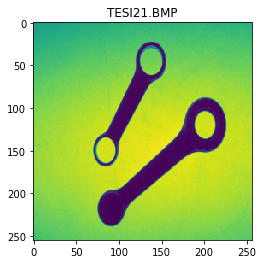

In [4]:
# read the image and store it
image = cv2.imread("../data/" + task1_image_filenames[index], cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
plt.title(task1_image_filenames[index])
plt.show()

Drawing the histogram it is possible to observe two different regions that represents the two semantically different parts of the image, the foreground, which is darker, and the background, which is brighter. The foreground is more restricted to a smaller range of intensities whereas the background present a wider range due to illumination conditions. 

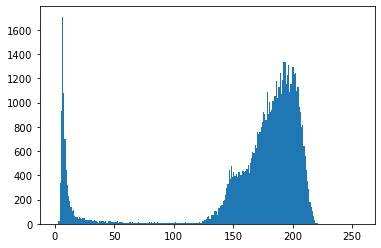

In [5]:
_ = plt.hist(image.ravel(),256,[0,256])

To confirm this observation it is possible to ignore it and try to increase even more the contrast using the Histogram Equalization, but as expected, the obtained result is not better.  

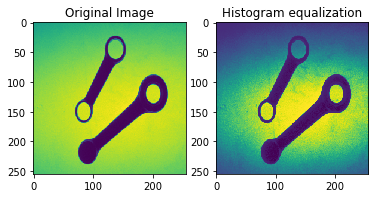

In [6]:
equalized = cv2.equalizeHist(image)

plt.subplot(1,2,1)
plt.title("Original Image")
_ = plt.imshow(image)

plt.subplot(1,2,2)
plt.title("Histogram equalization")
_ = plt.imshow(equalized)

Then excluded the presence of noise in the image it is possible to jump to the next step: segmentantion. The objective is to divide the foreground from the background and obtain a more useful binary image.

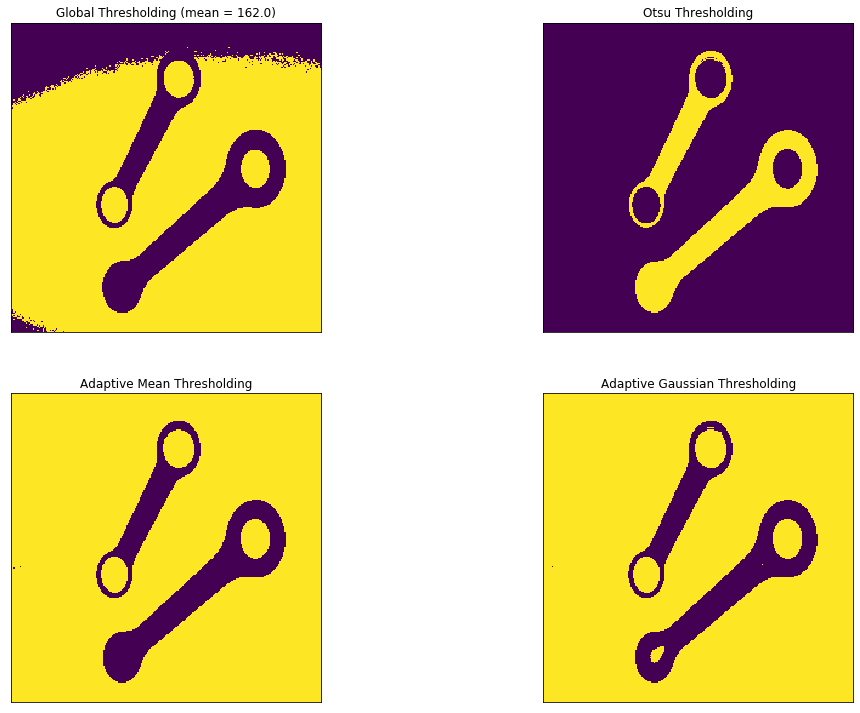

In [7]:
# try out different segmentation techniques to choose the proper one
binay_threshold = round(np.mean(image))
ret_binary, th_binary = cv2.threshold(image, binay_threshold, 255, cv2.THRESH_BINARY)
ret_otsu, th_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
th_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 47, 14)
th_gaussian = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 47, 14)

titles = ['Global Thresholding (mean = ' + str(binay_threshold) + ')', 'Otsu Thresholding', 'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [th_binary, th_otsu, th_mean, th_gaussian]

# plot them to make comparisons
plt.figure(figsize=(17.5, 12.5))

for i, img in enumerate(images):
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

From previous images it is possible to observe that with variation of the intensity on the background the global thresholding with the mean does not handle correctly the segmentation, because the regions may occupy in each image different portions of the total area, for this reason using the mean or other percentiles must be abandoned. Both the Adaptive Mean and the Gaussian Thresholding must be tuned to reduce the intensity of noise on the background, but by doing so a terrible side effect generates holes inside the rods. The Otsu Thresholding is the most promising, because only in one image provides a small imprecise and jagged contour that may cause some troubles in successive operations. To solve this problem, a closing followed by a opening is needed. In addition, Otsu is a better choice because works without setting or tuning any parameter.

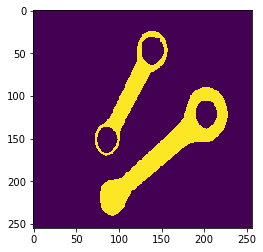

In [8]:
# close and open to remove small holes (especially for image "TESI21.BMP")
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))
th_otsu = cv2.morphologyEx(cv2.morphologyEx(th_otsu, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)
plt.imshow(th_otsu)
plt.show()

**strategies**
- To classify the rods in the two classes A or B it is necessary to count the holes. A first connected components labeling is applied to extract the rods, then, for each rod, another one is applied to the negative of the image containing only the specific rod to find its holes.
- The first connected components labeling finds also for each rod its barycentre.
- The second connected components labeling finds also barycentre and diameter (computed from the area) of the holes. 
- To find the orientation it is necessary to find firstly the major axis and then the angle between it and the horizontal axis. The major and minor axes are found deploying the covariance matrix obtained using the second order central moments of the image and the centroid of the blob (that can be computed using moments too)  
    
    $\mu{}_2{}_0 = M{}_2{}_0 - \cfrac{M{}_1{}_0}{M{}_0{}_0}M{}_1{}_0$  
    $\mu{}_0{}_2 = M{}_0{}_2 - \cfrac{M{}_0{}_1}{M{}_0{}_0}M{}_0{}_1$  
    $\mu{}_1{}_1 = M{}_1{}_1 - \cfrac{M{}_1{}_0}{M{}_0{}_0}M{}_1{}_0 = M{}_1{}_1 - \cfrac{M{}_0{}_1}{M{}_0{}_0}M{}_0{}_1$  
    $\mu'{}_2{}_0 = \cfrac{\mu{}_2{}_0}{\mu{}_0{}_0}$  
    $\mu'{}_0{}_2 = \cfrac{\mu{}_0{}_2}{\mu{}_0{}_0}$  
    $\mu'{}_1{}_1 = \cfrac{\mu{}_1{}_1}{\mu{}_0{}_0}$  
  
    \begin{equation*}
    cov[I(x, y)] = 
    \begin{pmatrix}
    \mu'{}_1{}_1 & \mu'{}_0{}_2 \\
    \mu'{}_2{}_0 & \mu'{}_1{}_1 \\
    \end{pmatrix}
    \end{equation*}
  
    $\theta = \cfrac{1}{2}arctan(\cfrac{2\mu'{}_1{}_1}{\mu'{}_2{}_0 - \mu'{}_0{}_2})$ 
    
    https://en.wikipedia.org/wiki/Image_moment
  
  
- The eigenvectors of this matrix correspond to the major and minor axes of the image intensity, so the orientation can thus be extracted from the angle of the eigenvector associated with the largest eigenvalue towards the axis closest to this eigenvector.
- The major and minor axes are then used to find the contact points between the rod and its oriented Minimum Enclosing Rectangle. During this procedure is also updated the width at the barycentre considering points that belong to the minor axis, in a similar way as the contact points are found.
- The contact points are finally used to compute the vertices of the Minimum Enclosing Rectangle, considering that its segments are parallel to major and minor axes and pass through the first.
- Finally, from the vertices of the Minimum Enclosing Rectangle, it is possible to measure the height and the width of the rod.

In [9]:
def mn_moment(data, m, n):
    ''' Measure the moments of the image given the order m and n
    Inputs:
        data - the binary image as numpy matrix
        m - order of the vertical axis
        n - order of the horizontal axis
    Output:
        the moment
    '''
    if data is None or data.size == 0 or m is None or n is None:
        raise ValueError("Missing some required arguments")
    
    nrows, ncols = data.shape
    y_indices, x_indices = np.mgrid[:nrows, :ncols]
    return (data * x_indices ** m * y_indices ** n).sum()

In [10]:
def moments_cov(data, centroid):
    ''' Create the covariance matrix using the second order central moments
    Inputs:
        data - the binary image as numpy matrix
        centroid - the centroid coordinate as array or tuple
    Output:
        the covariance matrix containing the moments
    '''
    if data is None or data.size == 0 or centroid is None:
        raise ValueError("Some required arguments are not correct")
    
    m10 = mn_moment(data, 1, 0)
    m01 = mn_moment(data, 0, 1)
    m00 = mn_moment(data, 0, 0)
    u11 = (mn_moment(data, 1, 1) - centroid[0] * m01) / m00
    u20 = (mn_moment(data, 2, 0) - centroid[0] * m10) / m00
    u02 = (mn_moment(data, 0, 2) - centroid[1] * m01) / m00
    return np.array([[u20, u11], [u11, u02]])

In [11]:
def contact_points(data, major_equation, minor_equation):
    ''' Find the contact points between major and minor axes parallel lines and the contour of the object 
    and measure the width at the barycentre
    Inputs:
        data - the binary image as numpy matrix
        major_equation - numpy array of type [a, b, c] representing the equation of the major axis
        major_equation - numpy array of type [a, b, c] representing the equation of the minor axis
    Outputs:
        c1 - on major axis, negative maximum
        c2 - on major axis, positive maximum
        c3 - on minor axis, negative maximum
        c4 - on minor axis, positive maximum
        barycentre_width - the width at the barycentre (along the minor axis)
    '''
    if data is None or data.size == 0 or major_equation is None or minor_equation is None:
        raise ValueError("Some required arguments are not correct")
    
    # initialize variables
    min_major_distance = math.inf
    max_major_distance = -math.inf
    min_minor_distance = math.inf
    max_minor_distance = -math.inf
    c1 = None
    c2 = None
    c3 = None
    c4 = None    
    min_barycentre_distance = math.inf
    max_barycentre_distance = -math.inf

    # for each point in the image, consider that coordinates could be misleading, moving in columns means changing the horizontal coordiante and vice vers
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data[y,x] == 255:
                # distance from the major axis as distance of a point to a line
                major_distance = (major_equation[1] * y + major_equation[0] * x + major_equation[2]) / math.sqrt((major_equation[0] ** 2) + (major_equation[1] ** 2))
                # distance from the minor axis as distance of a point to a line
                minor_distance = (minor_equation[1] * y + minor_equation[0] * x + minor_equation[2]) / math.sqrt((minor_equation[0] ** 2) + (minor_equation[1] ** 2))
                
                # update contact points searching for extremum in both horizontal and vertical axes
                if major_distance < min_major_distance:
                    min_major_distance = major_distance
                    c1 = [x, y]
                if major_distance > max_major_distance:
                    max_major_distance = major_distance 
                    c2 = [x, y]
                if minor_distance < min_minor_distance:
                    min_minor_distance = minor_distance
                    c3 = [x, y]
                if minor_distance > max_minor_distance:
                    max_minor_distance = minor_distance
                    c4 = [x, y]
                
                # if the point is close to the minor axes then it is considered in computing the width at the barycentre
                if abs(minor_distance) < 0.75:
                    # the distances are computed on both directions and summed to obtain the final value
                    if major_distance < min_barycentre_distance:
                        min_barycentre_distance = major_distance
                    if major_distance > max_barycentre_distance:
                        max_barycentre_distance = major_distance
    
    return c1, c2, c3, c4, abs(min_barycentre_distance) + abs(max_barycentre_distance)

In [12]:
def line_intersection(p1, p2, m1, m2):
    ''' Intersect 2 lines given 2 points and the associated slopes 
    Inputs:
        p1 - first point of first line [x,y]
        p2 - fist point of second line [x,y]
        m1 - slope of first line
        m2 - slope of second line
    Outputs:
        res - an array containing the intersection point of the two lines if exists, an array of np.nan otherwise
    '''
    if p1 is None or p2 is None or m1 is None or m2 is None:
        raise ValueError("Some required arguments are not correct")

    # prepare the matrices to solve the linear system of equations to find the intersection if there is
    a = np.array([[-m1, 1],
                  [-m2, 1]])
    b = np.array([p1[1] - m1 * p1[0], p2[1] - m2 * p2[0]])
    try:
        res = np.linalg.solve(a, b)
    except:
        res = np.array([np.nan, np.nan])

    return res

In [13]:
def main(image): 
    ''' The core of the project, contains the main algorithm to solve the problem 
    Inputs:
        image - the image to be processed as numpy matrix
    Outputs:
        rods - list of dictionaries containing all the results for each rod
    '''
    if image is None or image.size == 0:
        raise ValueError("Some required arguments are not correct")
    
    # find rods as connected components using a specific connectivity value  
    rod_connectivity = 4

    # rod_num, is the number of rods
    # rod_labelled_image, is the original image where each pixel is sunstituted by the correct label
    # rod_info, contains some informations about the blobs, as the area
    # rod_centroids, contains the centroid of each blob
    rod_num, rod_labelled_image, rod_info, rod_centroids = cv2.connectedComponentsWithStats(image, rod_connectivity, cv2.CV_32S)
    labels = np.unique(rod_labelled_image)
    print("Labels found {}".format(rod_num))
    
    # consider as a background the blob with maximum area
    background_label = np.argmax(rod_info[:,4])

    # rods is a list of dictionaries containing the requested information for each rod
    rods = []

    # for each label, so rod
    for label in labels:
        # exclude background
        if label != background_label:
            
            # create a binary image from the original one considering the labelled image: only the current rod will have the foreground value
            rod_image = th_otsu.copy()
            rod_image[rod_labelled_image == label] = 255
            rod_image[rod_labelled_image != label] = 0

            # create a binary image from the binary of the rod as its negative: only the holes of the current rod will have the foreground value
            hole_image = 255 - rod_image    

            # find holes as connected components
            hole_connectivity = 4
            hole_num, hole_labelled_image, hole_info, hole_centroids = cv2.connectedComponentsWithStats(hole_image, hole_connectivity, cv2.CV_32S)

            # exclude background and rod
            ignore_index = (np.argsort(hole_info[:,4])[::-1])[0:2]
  
            rod = {"index":label}
            rods.append(rod)

            rods[-1]["area"] = rod_info[label][4]
            rods[-1]["centroid"] = rod_centroids[label].round().astype(np.int)
            
            rods[-1]["holes"] = []
            
            counter = 0
            # iterating the holes if two are found then the rod is labelled, if more than 2 are found an error is raised
            for index, area in enumerate(hole_info[:,4]):
                if not (index in ignore_index) :
                    rods[-1]["holes"].append({"diameter":round(math.sqrt((area / math.pi)) * 2, 2), "centre":hole_centroids[index].round().astype(np.int)})
                    if counter == 0:
                        rods[-1]["type"] = "A"
                        counter += 1                        
                    elif counter == 1:
                        rods[-1]["type"] = "B"
                        counter += 1
                    elif counter > 1:
                        raise Exception("Error too many holes in a single rod index {}".format(index))


            if rods[-1]["holes"] == []:
                 raise Exception("Error too few holes in a single rod index")

            # use covariance matrix to find major and minor axes
            cov = moments_cov(rod_image, rods[-1]["centroid"])
            eigenvalues, eigenvectors = np.linalg.eig(cov)
            sort_indices = np.argsort(eigenvalues)[::-1]
            major_axes = eigenvectors[:, sort_indices[0]]
            minor_axes = eigenvectors[:, sort_indices[1]]

            #alpha = -math.sin(theta)
            #beta  =  math.cos(theta)
            alpha = major_axes[1]
            beta = major_axes[0]

            # find theta
            theta = -0.5 * math.atan2((2 * cov[0,1]), (cov[0,0] - cov[1,1]))
            rods[-1]["angle"] = round(math.degrees(theta), 2)

            # store major and minor equations
            major_equation = [alpha, -beta, beta * rods[-1]["centroid"][1] - alpha * rods[-1]["centroid"][0]]
            minor_equation = [beta, alpha, -beta * rods[-1]["centroid"][0] - alpha * rods[-1]["centroid"][1]]

            # find contact points and width at the barycentre
            c1, c2, c3, c4, barycentre_width = contact_points(rod_image, major_equation, minor_equation)
            rods[-1]["baricentre_width"] = round(barycentre_width, 2)
            
            # compute MER vertices
            v1 = line_intersection(c1, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v2 = line_intersection(c1, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v3 = line_intersection(c2, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v4 = line_intersection(c2, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])

            # measure length and width
            rods[-1]["lengtt"] = round(math.sqrt(((v1[0] - v2[0])**2) + ((v1[1] - v2[1])**2)), 2)
            rods[-1]["width"] = round(math.sqrt(((v1[0] - v3[0])**2) + ((v1[1] - v3[1])**2)), 2)

            # Draw        
            # MER
            plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color="#0000ff") #blue
            plt.plot([v2[0], v4[0]], [v2[1], v4[1]], color="#ff0000") #red
            plt.plot([v3[0], v1[0]], [v3[1], v1[1]], color="#c932c1") #purple
            plt.plot([v4[0], v3[0]], [v4[1], v3[1]], color="#00ff00") #green

            # Major and minor axes
            scale = 20
            plt.plot([major_axes[0] * -scale * 2 + rods[-1]["centroid"][0], major_axes[0] * scale * 2 + rods[-1]["centroid"][0]],
                     [major_axes[1] * -scale * 2 + rods[-1]["centroid"][1], major_axes[1] * scale * 2 + rods[-1]["centroid"][1]], color='black')
            plt.plot([minor_axes[0] * -scale + rods[-1]["centroid"][0], minor_axes[0] * scale + rods[-1]["centroid"][0]],
                     [minor_axes[1] * -scale + rods[-1]["centroid"][1], minor_axes[1] * scale + rods[-1]["centroid"][1]], color='black')
            plt.imshow(rod_image)
            plt.show()
            print(rods[-1])
    return rods

Labels found 3


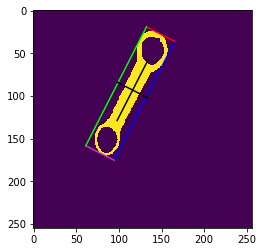

{'index': 1, 'area': 2480, 'centroid': array([116,  93]), 'holes': [{'diameter': 29.03, 'centre': array([139,  47])}, {'diameter': 26.49, 'centre': array([ 86, 151])}], 'type': 'B', 'angle': 62.94, 'baricentre_width': 18.78, 'lengtt': 156.5, 'width': 37.26}


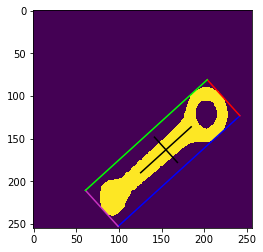

{'index': 2, 'area': 5285, 'centroid': array([155, 163]), 'holes': [{'diameter': 28.1, 'centre': array([202, 121])}], 'type': 'A', 'angle': 42.25, 'baricentre_width': 22.6, 'lengtt': 192.92, 'width': 56.98}


[{'index': 1,
  'area': 2480,
  'centroid': array([116,  93]),
  'holes': [{'diameter': 29.03, 'centre': array([139,  47])},
   {'diameter': 26.49, 'centre': array([ 86, 151])}],
  'type': 'B',
  'angle': 62.94,
  'baricentre_width': 18.78,
  'lengtt': 156.5,
  'width': 37.26},
 {'index': 2,
  'area': 5285,
  'centroid': array([155, 163]),
  'holes': [{'diameter': 28.1, 'centre': array([202, 121])}],
  'type': 'A',
  'angle': 42.25,
  'baricentre_width': 22.6,
  'lengtt': 192.92,
  'width': 56.98}]

In [14]:
main(th_otsu)

## Task 2

### Change 1

In [15]:
# file names of the task 2 change 1
task2a_image_filenames = [
    "TESI44.BMP",
    "TESI47.BMP",
    "TESI48.BMP",
    "TESI49.BMP",
    ]

In [16]:
index = 0

**Strategies**
The previous implementation already detect objects without holes like screws, raising an exception, because in task 1 are not considered legal. The problem is then limited to detect washers. To solve this problem is possible to:
- check if the detected object has a circular form, extracting the contour and applying the Haralick’s Circularity
- check if the detected object has a circular form, using the Hough Transform
- check if the distance between the object's barycentre and its hole barycentre is small

All the techniques need to set parameters, the first one need a single threshold, the second one a lot of parameters to identify the circles and the third one a single threshold. The first one needs the contour while the third one uses informations gained in the normal process of recognition of type A and B, so it's more computationally efficient.

In [17]:
minimum_distance_between_barycentres = 5
def task1c_rod_filter(rod_centroid, hole_centroid):
    '''
    Inputs:
        rod_centroid - rod position as numpy array
        hole_centroid - hole position as numpy array
    Outputs:
        True if the rod must be filtered and not considered
    '''
    if rod_centroid is None or rod_centroid.size == 0 or hole_centroid is None or hole_centroid.size == 0:
        raise ValueError("Some required arguments are not correct")
        
    distance = math.sqrt((hole_centroid[0] - rod_centroid[0])** 2 + (hole_centroid[1] - rod_centroid[1])** 2)
    print(distance)
    if distance < minimum_distance_between_barycentres:
        return True
    return False

### Change 2

The main challenge in dividing connected rods is represented by the presence of low density areas such as the circles that are prone to vanish even after light morphology operations. For this reason is not easy to detect when an isolated small portion of a rod, such as a semicircle shape, belongs to the rod or to another one.

In [18]:
task2b_image_filenames = [
    "TESI50.BMP",
    "TESI51.BMP",
]

index = 1

task2b_image = cv2.imread("../data/" + task2b_image_filenames[index], cv2.IMREAD_GRAYSCALE)

The opencv library includes the implementation of a very intersting algorithm called Watershed Transformation. The main idea is to consider the image as a topographic surface and the labeling process as a flooding of this space. Opencv deploys a marker-controlled Watershed Transformation, which is more reliable and obtains better results. The markers represent the starting points of the flooding and are obtained generating images in which each foreground region (rod) is represented by a secured subset of its pixels, a smart way to obtain this is to threshold the distance transformation of the image. Another tested approach was to compute the skeleton of an image but the links between touching rods were too strong. Dilating the image we obtain a new image which surely contains the correct background. The difference between the image containing the sure parts of each rod and the background contains the areas which are are more crictical to label, and contains also the contacting points. Then the watershed function is called passing the distance transformation as a RGB image and the labelled connected components considering that the unknown region must have 0 as a label.

Details on:  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html  
http://www.cmm.mines-paristech.fr/~beucher/wtshed.html

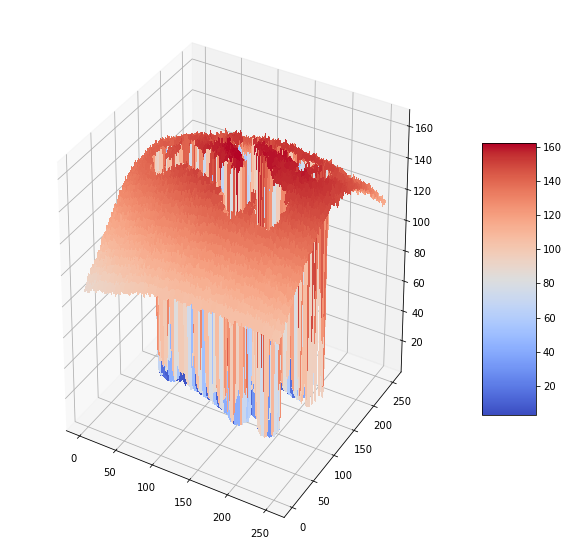

In [19]:
# a tridimensional representation of the image that recall a topographic surface
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(task2b_image.shape[1]), range(task2b_image.shape[0]))
surface = ax.plot_surface(x, y, task2b_image, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
_ = fig.colorbar(surface, shrink=0.5, aspect=5)

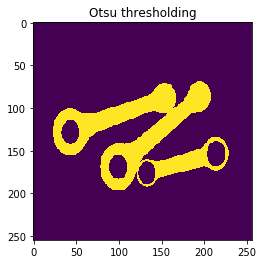

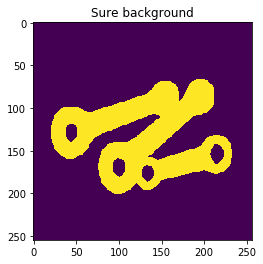

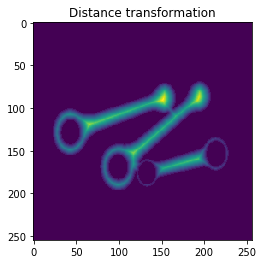

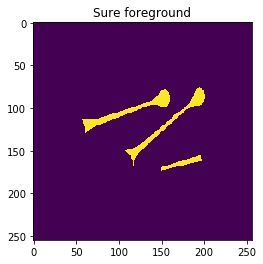

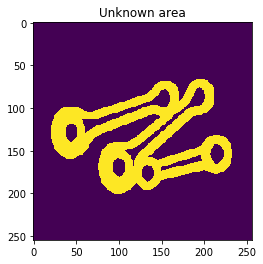

In [20]:
# segmentation
_, task2b_th_otsu = cv2.threshold(task2b_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.title("Otsu thresholding")
plt.imshow(task2b_th_otsu)
plt.show()

# close the image to cover some holes
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
opening = cv2.morphologyEx(task2b_th_otsu, cv2.MORPH_CLOSE, kernel, iterations = 2)

# sure background area as a dilation
sure_bg = cv2.dilate(task2b_th_otsu, kernel, iterations=2)
plt.title("Sure background")
plt.imshow(sure_bg)
plt.show()

# Finding sure foreground area as a threshold of the distance transformation
mask_size = 5
dist_transform = cv2.distanceTransform(task2b_th_otsu, cv2.DIST_L2, mask_size)
plt.title("Distance transformation")
plt.imshow(dist_transform)
plt.show()

_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
plt.title("Sure foreground")
plt.imshow(sure_fg)
plt.show()

# Finding unknown regions
unknown = cv2.subtract(sure_bg, sure_fg)
plt.title("Unknown area")
plt.imshow(unknown)
plt.show()

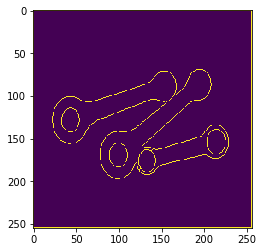

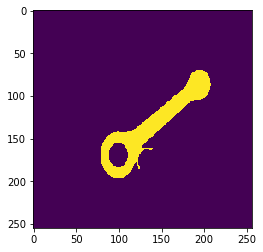

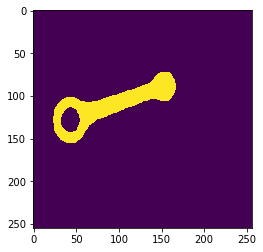

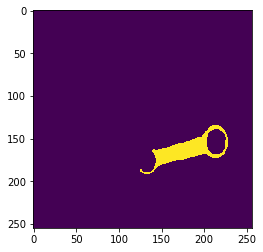

In [21]:
# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Apply some preprocessing because the watershed algorithm consider 0 labelled regions as the unknowns
# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Prepare data
markers = markers.astype(np.int32)
dist_transform = np.uint8(dist_transform)

# Apply algorithm
resulting_regions = cv2.watershed(cv2.cvtColor(task2b_image, cv2.COLOR_GRAY2BGR), markers)

# Print labelled parts
for region in np.unique(resulting_regions):
    # ignore background
    if region == 1:
        continue

    region_image = np.zeros(task2b_th_otsu.shape)
    region_image[resulting_regions == region] = 255
    
    plt.imshow(region_image)
    plt.show()

Unfortunalely the result are not usable, maybe other refinements are needed, for example dealing better with small and low density regions of the image which tends to be not clearly connected to the rest of the rod. Otherwise can be implemented an enhancement of the Watershed algorithm called P Algorithm

### Change 3

In [22]:
# file names of the task 2 change 3
task2c_image_filenames = [
    "TESI90.BMP",
    "TESI92.BMP",
    "TESI98.BMP"]

task2c_image_rods_per_image = 3

In [23]:
index = 0

The most intuitive ideas suggest to apply some methods to get rid of the iron powder from the image, or to detect and ignore all of them during the other operations. The final approach combine both ideas as the first option is not able to remove all of them without altering irreversibly the image. It's worth to say that in general from change 1 objects without holes are already ignored.

In [24]:
def preprocessing(image, allow_print=True):
    ''' operations: Otsu -> closing -> opening -> dilation
    Inputs:
        image - the image to preprocess as numpy matrix
        allow_print - True print preprocessing results
    Outputs:
        the preprocessed image
    '''
    if image is None or image.size == 0 or allow_print is None:
        raise ValueError("Some required arguments are not correct")

    if allow_print:
        f = plt.figure(figsize=(10,10))
        ax = f.add_subplot(221)
        plt.title("Original")
        ax.imshow(image)

    # segmentation
    task2c_ret_otsu, task2c_th_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # close it
    task2c_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))

    closed = cv2.morphologyEx(task2c_th_otsu, cv2.MORPH_CLOSE, task2c_kernel)
    if allow_print:
        ax = f.add_subplot(222)
        plt.title("Closing")
        ax.imshow(closed)

    # then open it
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, task2c_kernel)
    if allow_print:
        ax = f.add_subplot(223)
        plt.title("Opening")
        ax.imshow(opened)

    # and finally dilate it
    task2c_dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    dilated = cv2.dilate(opened, task2c_dilation_kernel, iterations = 1)
    if allow_print:
        ax = f.add_subplot(224)
        plt.title("Dilation")
        ax.imshow(dilated)
        plt.show()
    
    return dilated

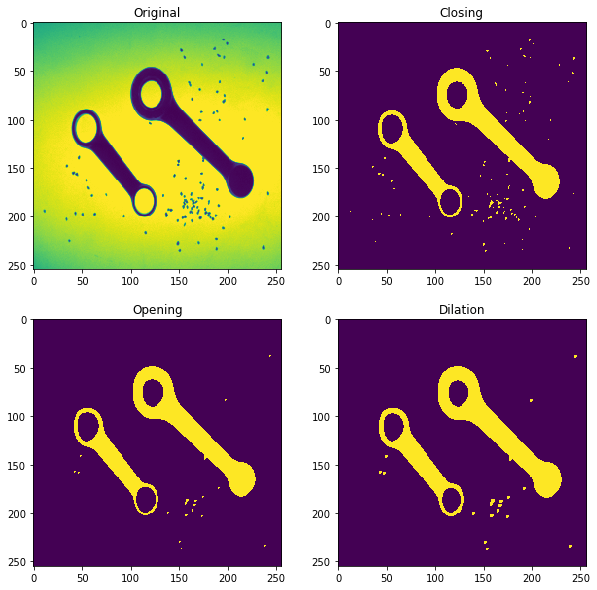

In [25]:
task2c_image = cv2.imread("../data/" + task2c_image_filenames[index], cv2.IMREAD_GRAYSCALE)
    
preprocessed_image = preprocessing(task2c_image)

Opening and closing has the general good effect of removing small particles, but a too aggressive approach (large kernel) has the drawback of corrupting the rods' circles, which are essential to classify the rod's type. A possible solution is to open the image with a small kernel to remove small particles, dilate the whole image a bit to close possible broken circles and set a threshold value to ignore the small remaining areas during the following phases.

In [26]:
mean_num = 0
mean_den = 0
# default value
area_threshold = 15

for filename in task2c_image_filenames:
    image = cv2.imread("../data/" + filename, cv2.IMREAD_GRAYSCALE)

    preprocessed = preprocessing(image, False)
    _, _, blob_info, _ = cv2.connectedComponentsWithStats(preprocessed, 4, cv2.CV_32S)
    
    for blob in np.sort(blob_info[:,4])[-5::-1]:
        mean_num += blob
        mean_den += 1
    
if mean_den != 0:  
    area_threshold = mean_num / mean_den
    print("Threshold obtained with the mean: {}".format(area_threshold))
else:
    print("No samples avaiable")

Threshold obtained with the mean: 10.05


In [27]:
# exclude blobs with area lower than a specific threshold
def task2c_rod_filter(rod_info):
    '''
    Inputs:
        rod_info - a numpy array containing information on the blob retrievable from the opencv connectedComponentsWithStats function
    Outputs:
        True if the rod must be filtered and not considered
    '''
    if rod_info is None or rod_info.size == 0:
        raise ValueError("Some required arguments are not correct")

    # if the area is below the threshold the blob must be filtered
    if rod_info[4] < area_threshold:
        return True
    return False